In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import ldspec
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
import seaborn as sns
import statsmodels.formula.api as smf
from adjustText import adjust_text

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/LDSPEC_data/results/fig_res'
TAB_PATH = '/n/groups/price/martin/LDSPEC_data/results/tables'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/trait_info.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST_INDPT = list(DF_TRAIT.index[DF_TRAIT['Indpt']])
print("n_trait=%d" % DF_TRAIT.shape[0])
print("n_trait_indpt=%d" % len(TRAIT_LIST_INDPT))

DF_ANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.tsv', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {
    'common' : '#78ADD2', 
    'lf' : '#FFB26E',
    ('p0_p100', 'common') : 'C0',
    ('p0_p100', 'lf') : 'C1',
    ('n100_p0', 'common') : 'C2',
    ('n100_p0', 'lf') : 'C3',
}

MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=70
n_trait_indpt=29
n_annot=45
n_pannot=34


### Load results and meta-analysis

In [3]:
# Load results 
DIC_RES_PATH = {
    'md_bsl' : DATA_PATH + '/ldspec_res_092223.bsl/@t',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/ldspec_res_092223.prox_gene_fct_all_ld/@t',
}
md0 = 'md_bsl'

# Load .pickle files: dic_res[md][trait] = .pickle
dic_res = {}
missing_list = []
for md in DIC_RES_PATH:
    dic_res[md] = {}   
    temp_list = TRAIT_LIST if md=='md_prox_gene_fct_all_ld' else TRAIT_LIST_INDPT
    for i,trait in enumerate(temp_list):
        if os.path.exists(DIC_RES_PATH[md].replace("@t", trait) + ".pickle"):
            with open(DIC_RES_PATH[md].replace("@t", trait) + ".pickle", "br") as f:
                dic_res[md][trait] = pickle.load(f)
            # Check avgr
            with open(DIC_RES_PATH[md].replace("@t", trait) + ".sbatch.log", "r") as f:
                for line in f:
                    if 'Detected AVGR for' in line:
                        line = line.strip()
                        n1,n2 = line.split(' ')[3].split('/')
                        if n1!=n2: 
                            print("Missing AVGR: %-20s %-35s %s %s" % (md, trait, i+1, line))
        else:
            print("Missing %-10s %-30s %s" % (md, trait, i+1))
            if trait not in missing_list: 
                missing_list.append(trait)
                
# Check AN_list and pAN_list are same across traits for a given method
print('Check matching of AN_list and pAN_list')
for md in DIC_RES_PATH:
    print('    %s' % md)
    AN_list_md = list(dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['tau'].index)
    pAN_list_md = list(dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['omega'].index)
    for trait in dic_res[md]:
        if set(dic_res[md][trait]['summary']['tau'].index) != set(AN_list_md):
            print('    AN_list not match: %s' % trait)
        if set(dic_res[md][trait]['summary']['omega'].index) != set(pAN_list_md):
            print('    pAN_list not match: %s' % trait)

# Collect info
print('n_missing_trait=%d' % len(missing_list))
AN_list = list(dic_res[md0][TRAIT_LIST_INDPT[0]]['summary']['tau'].index)
print('AN_list=%d' % len(AN_list))
pAN_list = []
for md in DIC_RES_PATH:
    pAN_list += [x for x in dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['omega'].index if x not in pAN_list]
print('pAN_list=%d' % len(pAN_list))

# Trait with h2_z>5
TRAIT_LIST_META = []
for trait in TRAIT_LIST_INDPT:
    h2 = dic_res[md0][trait]['summary']['tau'].loc['AN:all', 'h2']
    h2_se = dic_res[md0][trait]['summary']['tau'].loc['AN:all', 'h2_se']
    h2_z = h2 / h2_se
    if h2_z > 5:
        TRAIT_LIST_META.append(trait)
    else:
        print('    %-20s    h2=%0.3f    h2_z=%0.2f' % (trait, h2, h2_z))
print('%d/%d traits with h2z>5' % (len(TRAIT_LIST_META), len(TRAIT_LIST_INDPT)))

Check matching of AN_list and pAN_list
    md_bsl
    md_prox_gene_fct_all_ld
n_missing_trait=0
AN_list=165
pAN_list=136
29/29 traits with h2z>5


In [4]:
# Meta-analysis
dic_term_list = {
    'tau': ['tau', 'h2', 'scv', 'h2_enrich', 'scv_enrich', 'h2_shrink'], 
    'omega': ['omega', 'cov', 'cor', 'ecov', 'ecor'],
}

dic_res_meta = {}
for md in DIC_RES_PATH:
    dic_res_meta[md] = {}
    res_tau_list = [dic_res[md][x]['summary']['tau'] for x in TRAIT_LIST_META]
    res_omega_list = [dic_res[md][x]['summary']['omega'] for x in TRAIT_LIST_META]
    for res in ['tau', 'omega']:
        dic_res_meta[md][res] = pd.DataFrame(
            index = dic_res[md][TRAIT_LIST_INDPT[0]]['summary'][res].index, 
            columns = ['%s%s'%(x,y) for x in dic_term_list[res] for y in ['', '_se', '_p']],
            dtype=float,
        )
        # Meta-analysis 
        for term in dic_term_list[res]:
            for row in dic_res_meta[md][res].index:
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                dic_res_meta[md][res].loc[row, [term, '%s_se'%term, '%s_p'%term]] = mean_,se_,p_

/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:122: RuntimeWarning: overflow encountered in multiply
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:102: RuntimeWarning: divide by zero encountered in true_divide
  vwts = 1.0 / variances
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:106: RuntimeWarning: invalid value encountered in float_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))


In [5]:
DIST_FILE = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/pannot/stats/@.dist.tsv'
DF_DIST = None
for pAN in pAN_list:
    if os.path.exists(DIST_FILE.replace('@', pAN.replace('pAN:', ''))):
        fpath = DIST_FILE.replace('@', pAN.replace('pAN:', ''))
    else:
        print('Missing: %s' % pAN)

    temp_df = pd.read_csv(fpath, sep='\t')
    temp_df.columns = ['bin', 'left', 'right', pAN]
    if DF_DIST is None:
        DF_DIST = temp_df.copy()
    else:
        DF_DIST = DF_DIST.join(temp_df[[x for x in temp_df if x not in DF_DIST]])

for pAN in pAN_list:
    if pAN not in DF_DIST:
        DF_DIST[pAN] = 0

In [6]:
# Write tables
md = 'md_prox_gene_fct_all_ld'
for res in ['tau', 'omega']:
    # Individual trait results
    temp_list = []
    for trait in TRAIT_LIST:
        temp_df = dic_res[md][trait]['summary'][res].copy()
        temp_df['trait'] = trait
        temp_df = temp_df[['trait'] + [x for x in temp_df if x!='trait']]
        temp_list.append(temp_df)
    temp_df = pd.concat(temp_list, axis=0)
    temp_df.to_csv(TAB_PATH+'/ldspec.%s.%s.tsv' % (md,res), sep='\t', index=False)
    
    # Meta-analyzed results
    dic_res_meta[md][res].to_csv(TAB_PATH+'/ldspec_meta.%s.%s.tsv' % (md,res), sep='\t')

### Figure 2 : cor + dist plot
- proxy_0_100, proxy_100_1000, proxy_1000_10000
- 'exon', 'exonic_gene', 'cS2G_promoter', 'protein_domain', 'gene'

In [7]:
plot_dic = {
    'proxy_0_100' : 'md_prox_gene_fct_all_ld',
    'proxy_100_1000' : 'md_prox_gene_fct_all_ld',
    'proxy_1000_10000' : 'md_prox_gene_fct_all_ld',
    'exon' : 'md_prox_gene_fct_all_ld',
    'exonic_gene' : 'md_prox_gene_fct_all_ld',
    'cS2G_promoter' : 'md_prox_gene_fct_all_ld', 
    'protein_domain' : 'md_prox_gene_fct_all_ld', 
    'gene' : 'md_prox_gene_fct_all_ld',
}
plot_list = list(plot_dic)

for x in plot_dic:
    if plot_dic[x] not in dic_res_meta:
        print('method %s not in dic_res_meta' % plot_dic[x])
        continue
    row = 'pAN:%s_ld_n100_p0_maf_lf_block'%x
    if row not in dic_res_meta[plot_dic[x]]['omega'].index:
        print('pAN %s not in dic_res_meta[plot_dic[x]][omega].index' % row)

# hypothesis: 136


,cor.p0_p100.lf,cor.p0_p100.lf.se,cor.p0_p100.lf.p,cor.p0_p100.common,cor.p0_p100.common.se,cor.p0_p100.common.p,cor.n100_p0.lf,cor.n100_p0.lf.se,cor.n100_p0.lf.p,cor.n100_p0.common,cor.n100_p0.common.se,cor.n100_p0.common.p
proxy_0_100,-0.372667,0.086019,1.033280e-04,-0.149789,0.041595,0.001273,-0.007519,0.158300,0.952470,0.121764,0.053333,0.035891
proxy_100_1000,-0.067393,0.044560,1.962725e-01,-0.027577,0.021033,0.059695,0.079414,0.048828,0.148719,-0.011490,0.019110,0.532452
proxy_1000_10000,-0.067841,0.011070,1.807891e-07,0.006182,0.004613,0.079459,-0.057560,0.012212,0.000019,0.010227,0.004905,0.038869
exon,-0.162129,0.036283,8.618197e-05,-0.079185,0.031210,0.001973,-0.071329,0.045022,0.062070,-0.038271,0.032371,0.065731
exonic_gene,-0.134591,0.020980,6.108352e-09,-0.057774,0.027905,0.060979,-0.056342,0.027078,0.016313,-0.000868,0.027157,0.905108
cS2G_promoter,-0.373330,0.076342,2.455972e-06,-0.070065,0.027965,0.088598,-0.125096,0.095654,0.051780,-0.015557,0.028778,0.490192
protein_domain,-0.171995,0.039101,7.922047e-05,-0.057508,0.053520,0.224084,-0.167262,0.044602,0.000247,0.050136,0.051991,0.537500
gene,-0.004784,0.001468,6.358230e-03,-0.009411,0.003088,0.002120,0.000294,0.001561,0.972750,-0.008011,0.003126,0.007824


,ecor.p0_p100.lf,ecor.p0_p100.lf.se,ecor.p0_p100.lf.p,ecor.p0_p100.common,ecor.p0_p100.common.se,ecor.p0_p100.common.p,ecor.n100_p0.lf,ecor.n100_p0.lf.se,ecor.n100_p0.lf.p,ecor.n100_p0.common,ecor.n100_p0.common.se,ecor.n100_p0.common.p
proxy_0_100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proxy_100_1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proxy_1000_10000,6.832861e-09,1.085884e-09,7.735527e-08,-5.510787e-10,4.320294e-10,0.116372,NaN,NaN,NaN,-2.458180e-09,1.159320e-09,0.034903
exon,-1.492750e-01,3.599661e-02,2.598063e-04,-7.592821e-02,3.101751e-02,0.003307,-0.071089,0.045041,0.057104,-4.276941e-02,3.206874e-02,0.047604
exonic_gene,-1.291062e-01,2.099330e-02,2.968263e-08,-5.580961e-02,2.787097e-02,0.071487,-0.056164,0.027115,0.017128,-1.959861e-03,2.709929e-02,0.877329
cS2G_promoter,-3.675758e-01,7.702770e-02,6.651372e-06,-6.746075e-02,2.792377e-02,0.114267,-0.126640,0.095796,0.054551,-1.769689e-02,2.875747e-02,0.451248
protein_domain,-1.690132e-01,3.911268e-02,1.192066e-04,-5.607948e-02,5.345246e-02,0.239114,-0.166911,0.044618,0.000259,4.979762e-02,5.193920e-02,0.541382
gene,2.756181e-04,1.538399e-03,8.861440e-01,-9.109171e-03,3.131071e-03,0.003381,0.003805,0.001686,0.100625,-8.436068e-03,3.142426e-03,0.006318


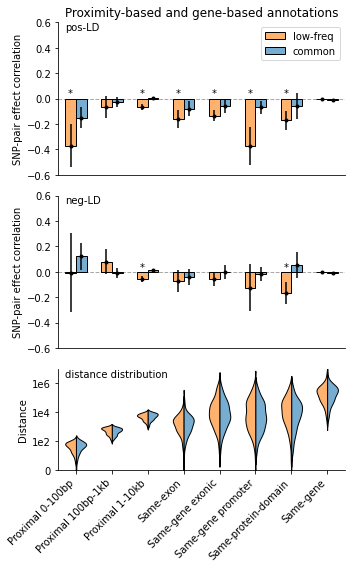

In [10]:
df_plot = pd.DataFrame(
    index = plot_list, dtype = float, 
    columns = [
        '%s.%s.%s%s' % (x, y, z, q)
        for x in ['cor', 'ecor'] 
        for y in ['n100_p0', 'p0_p100'] 
        for z in ['lf', 'common'] 
        for q in ['', '.se', '.p', '.fwer', '.sig_str'] 
    ]
)  
print('# hypothesis: %d' % len(pAN_list))
for term in ['cor', 'ecor']:  
    for lbin in ['n100_p0', 'p0_p100']:
        for mbin in ['lf', 'common']:
            for pannot in plot_list:
                row = 'pAN:%s_ld_%s_maf_%s_block' % (pannot, lbin, mbin)
                df_plot.loc[pannot, '%s.%s.%s' % (term, lbin, mbin)] = \
                    dic_res_meta[plot_dic[pannot]]['omega'].loc[row, '%s' % term]
                df_plot.loc[pannot, '%s.%s.%s.se' % (term, lbin, mbin)] = \
                    dic_res_meta[plot_dic[pannot]]['omega'].loc[row, '%s_se' % term]
                df_plot.loc[pannot, '%s.%s.%s.p' % (term, lbin, mbin)] = \
                    dic_res_meta[plot_dic[pannot]]['omega'].loc[row, '%s_p' % term]
            df_plot['%s.%s.%s.fwer' % (term, lbin, mbin)] = \
                df_plot['%s.%s.%s.p' % (term, lbin, mbin)] * len(pAN_list)
            df_plot['%s.%s.%s.sig_str' % (term, lbin, mbin)] = \
                ['*' if x<0.05 else '' for x in df_plot['%s.%s.%s.fwer' % (term, lbin, mbin)]]
    display(df_plot[[
        '%s.%s.%s%s' % (term, y, z, q) 
        for y in ['p0_p100', 'n100_p0'] for z in ['lf', 'common'] for q in ['', '.se', '.p']
    ]])
df_plot.to_csv(TAB_PATH+'/fig2.tsv', sep='\t')

# df_plot_dist
col_list = [
    'pAN:%s_ld_%s_maf_%s_block' % (x, y, z) 
    for x in plot_list for y in ['n100_p0', 'p0_p100'] for z in ['lf', 'common']
]
temp_df = DF_DIST[['left', 'right'] + col_list].copy()
temp_df = temp_df.loc[temp_df[col_list].sum(axis=1)>0].copy()

n_pts,v_dist,v_pannot,v_mbin = 100,[],[],[]
for pannot in plot_list:
    for mbin in ['lf', 'common']:
        row = 'pAN:%s_maf_%s_block' % (pannot, mbin) 
        row1 = 'pAN:%s_ld_%s_maf_%s_block' % (pannot, 'p0_p100', mbin) 
        row2 = 'pAN:%s_ld_%s_maf_%s_block' % (pannot, 'n100_p0', mbin) 
        temp_df[row] = temp_df[[row1, row2]].sum(axis=1)
        for dbin in temp_df.index:
            n_sample = round(temp_df.loc[dbin, row] / temp_df[row].sum() * n_pts)
            temp_v = np.random.rand(n_sample)
            temp_v *= temp_df.loc[dbin,'right'] - temp_df.loc[dbin,'left']
            temp_v += temp_df.loc[dbin, 'left']
            v_dist.extend(np.log10(temp_v))
            v_pannot += [pannot] * n_sample
            v_mbin += [DIC_NAME[mbin]] * n_sample
df_plot_dist = pd.DataFrame(data={'dist' : v_dist, 'pannot' : v_pannot, 'mbin' : v_mbin})

# Figure
plt.figure(figsize=[3+0.25*len(plot_list),8])
# Upper: pos-LD
gs = gridspec.GridSpec(3, 1, height_ratios=[1.5, 1.5, 1]) 
ax = plt.subplot(gs[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i_mbin,mbin in enumerate(['lf', 'common']):
    plt.errorbar(
        np.arange(df_plot.shape[0])-0.15+0.3*i_mbin, df_plot['cor.p0_p100.%s'%mbin], 
        yerr=df_plot['cor.p0_p100.%s.se'%mbin]*1.96, fmt= '.', color='k',
    )    
    plt.bar(
        np.arange(df_plot.shape[0])-0.15+0.3*i_mbin, df_plot['cor.p0_p100.%s'%mbin], 
        width=0.3, alpha=1, linewidth=1, edgecolor='k', label=DIC_NAME[mbin], color=DIC_COLOR[mbin]
    )
    for i_row,row in enumerate(df_plot.index):
        plt.text(
            i_row-0.15+0.3*i_mbin, 
            max(0, (
                df_plot.loc[row, 'cor.p0_p100.%s'%mbin] + df_plot.loc[row,'cor.p0_p100.%s.se'%mbin] * 1.96
            )),
            df_plot.loc[row, 'cor.p0_p100.%s.sig_str'%mbin], ha='center', va='bottom',
        ) 

plt.xticks([])
plt.plot([-0.5, df_plot.shape[0]-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.ylim([-0.6, 0.6])
plt.text(-0.3, 0.6, 'pos-LD', ha='left', va='top')
plt.ylabel(DIC_NAME['cor'])
plt.title('Proximity-based and gene-based annotations')
plt.legend(loc='upper right')

# Middle: neg-LD
ax = plt.subplot(gs[1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i_mbin,mbin in enumerate(['lf', 'common']):
    plt.errorbar(
        np.arange(df_plot.shape[0])-0.15+0.3*i_mbin, df_plot['cor.n100_p0.%s'%mbin], 
        yerr=df_plot['cor.n100_p0.%s.se'%mbin]*1.96, fmt= '.', color='k',
    )   
    plt.bar(
        np.arange(df_plot.shape[0])-0.15+0.3*i_mbin, df_plot['cor.n100_p0.%s'%mbin], 
        width=0.3, alpha=1, linewidth=1, edgecolor='k', label=DIC_NAME[mbin], color=DIC_COLOR[mbin]
    )
    for i_row,row in enumerate(df_plot.index):
        plt.text(
            i_row-0.15+0.3*i_mbin, 
            max(0, (
                df_plot.loc[row, 'cor.n100_p0.%s'%mbin] + df_plot.loc[row,'cor.n100_p0.%s.se'%mbin] * 1.96
            )),
            df_plot.loc[row, 'cor.n100_p0.%s.sig_str'%mbin], ha='center', va='bottom',
        ) 

plt.xticks([])
plt.plot([-0.5, df_plot.shape[0]-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.ylim([-0.6, 0.6])
plt.text(-0.3, 0.6, 'neg-LD', ha='left', va='top')
plt.ylabel(DIC_NAME['cor'])

# Lower : dist
ax = plt.subplot(gs[2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = sns.violinplot(
    data=df_plot_dist, x='pannot', y='dist', hue='mbin', hue_order=['low-freq', 'common'],
    palette=[DIC_COLOR['lf'], DIC_COLOR['common']], 
    width=0.6, order=df_plot.index, split=True, inner=None, linewidth=1, saturation=1,
)
ax.legend_.remove()
for art in ax.collections:
    art.set_edgecolor('k')
plt.xlabel('')
plt.ylabel('Distance')
plt.yticks([0, 2, 4, 6], ['0', '1e2', '1e4', '1e6'])
plt.xticks(np.arange(df_plot.shape[0]),[DIC_NAME[x] if x in DIC_NAME else x for x in df_plot.index],
           rotation=45, ha='right')
plt.ylim([0, 7])
plt.text(-0.3, 7, 'distance distribution', ha='left', va='top')
plt.tight_layout()
plt.savefig(FIG_PATH + '/fig2.pdf')
plt.show()

In [9]:
# JN p-value for difference 
md = 'md_prox_gene_fct_all_ld'
term = 'cor' 
prox_list = ['proxy_0_100', 'proxy_100_1000', 'proxy_1000_10000']
gene_list = ['exon', 'exonic_gene', 'cS2G_promoter', 'protein_domain', 'gene']
compare_dic = {
    'prox_pos_ld;common;lf' : [('pAN:%s_ld_p0_p100_maf_@_block'%x, ('common', 'lf')) for x in prox_list],
    'gene_pos_ld;common;lf' : [('pAN:%s_ld_p0_p100_maf_@_block'%x, ('common', 'lf')) for x in gene_list],
    'prox;n100_p0;p0_p100' : [('pAN:%s_ld_@_maf_common_block'%x, ('n100_p0', 'p0_p100')) for x in prox_list] + \
    [('pAN:%s_ld_@_maf_lf_block'%x, ('n100_p0', 'p0_p100')) for x in prox_list],
    'gene;n100_p0;p0_p100' : [('pAN:%s_ld_@_maf_common_block'%x, ('n100_p0', 'p0_p100')) for x in gene_list] + \
    [('pAN:%s_ld_@_maf_lf_block'%x, ('n100_p0', 'p0_p100')) for x in gene_list],
}

n_hypothesis = len(pAN_list) / 2

df_jndif_list = []
for compare_term in compare_dic:
    print(compare_term)
    compare_list = compare_dic[compare_term]
    df_res = pd.DataFrame(
        columns=['pAN', 'strat1', 'start2', 'pAN1', 'mean1', 'se1', 'pAN2', 'mean2', 'se2', 
                 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str'], 
        dtype=float,
    )
    for i_pair, (pAN, (strat1, strat2)) in enumerate(compare_list):
        pAN1,pAN2 = pAN.replace('@', strat1),pAN.replace('@', strat2)
        esti_list,se_list = [],[]
        df_res.loc[i_pair, ['pAN', 'strat1', 'start2', 'pAN1', 'pAN2']] = [pAN, strat1, strat2, pAN1, pAN2]
        df_res.loc[i_pair, ['mean1', 'se1']] = dic_res_meta[md]['omega'].loc[pAN1, [term, '%s_se'%term]].values
        df_res.loc[i_pair, ['mean2', 'se2']] = dic_res_meta[md]['omega'].loc[pAN2, [term, '%s_se'%term]].values
        for trait in TRAIT_LIST_INDPT:
            temp_dic_jn = dic_res[md][trait]['summary']['dic_jn']
            esti1 = {x:y for x,y in zip(temp_dic_jn['res_pAN_list'], temp_dic_jn[term])}[pAN1]
            esti2 = {x:y for x,y in zip(temp_dic_jn['res_pAN_list'], temp_dic_jn[term])}[pAN2]
            temp_df = pd.DataFrame(data=temp_dic_jn['%s.jn'%term], columns=temp_dic_jn['res_pAN_list'])
            v_mean_jn, mat_cov_jn = ldspec.regress.bjn(
                [esti1 - esti2], temp_df[pAN1] - temp_df[pAN2], temp_dic_jn['v_h']
            )
            esti_list.append(v_mean_jn[0])
            se_list.append(np.sqrt(mat_cov_jn[0,0]))        
        mean_,se_ = ldspec.util.meta_analysis(np.array(esti_list), np.array(se_list))
        p_ = ldspec.util.zsc2pval(mean_ / se_)
        df_res.loc[i_pair, ['dif', 'dif_se', 'dif_p']] = [mean_, se_, p_]
    df_res['dif_fwer'] = df_res['dif_p'] * n_hypothesis
    print('# hypothesis: %d' % n_hypothesis)
    df_res['dif_sig_str'] = ['*' if x<0.05 else '' for x in df_res['dif_fwer']]
    
    df_res['pAN'] = [
        x.replace('pAN:','').replace('_proxy','').replace('_ld','').replace('_block','') 
        for x in df_res['pAN']
    ]
    display(df_res[[
        'pAN', 'strat1', 'start2', 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str', 
        'mean1', 'se1', 'mean2', 'se2', 
    ]])
    
    df_jndif_list.append(
        df_res[['pAN', 'strat1', 'start2', 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str']]
    )
df_jndif = pd.concat(df_jndif_list, axis=0)
df_jndif.to_csv(TAB_PATH+'/fig2.jndif.tsv', sep='\t', index=False)

prox_pos_ld;common;lf
# hypothesis: 68


,pAN,strat1,start2,dif,dif_se,dif_p,dif_fwer,dif_sig_str,mean1,se1,mean2,se2
0,proxy_0_100_p0_p100_maf_@,common,lf,0.223947,0.113865,4.920981e-02,3.346267e+00,,-0.149789,0.041595,-0.372667,0.086019
1,proxy_100_1000_p0_p100_maf_@,common,lf,0.029229,0.048678,5.481967e-01,3.727738e+01,,-0.027577,0.021033,-0.067393,0.044560
2,proxy_1000_10000_p0_p100_maf_@,common,lf,0.074126,0.012423,2.419509e-09,1.645266e-07,*,0.006182,0.004613,-0.067841,0.011070


gene_pos_ld;common;lf
# hypothesis: 68


,pAN,strat1,start2,dif,dif_se,dif_p,dif_fwer,dif_sig_str,mean1,se1,mean2,se2
0,exon_p0_p100_maf_@,common,lf,0.085772,0.057116,0.133166,9.055294,,-0.079185,0.031210,-0.162129,0.036283
1,exonic_gene_p0_p100_maf_@,common,lf,0.076581,0.039056,0.049902,3.393365,,-0.057774,0.027905,-0.134591,0.020980
2,cS2G_promoter_p0_p100_maf_@,common,lf,0.357045,0.087982,0.000049,0.003363,*,-0.070065,0.027965,-0.373330,0.076342
3,protein_domain_p0_p100_maf_@,common,lf,0.149887,0.084606,0.076463,5.199482,,-0.057508,0.053520,-0.171995,0.039101
4,gene_p0_p100_maf_@,common,lf,-0.005970,0.003714,0.107934,7.339507,,-0.009411,0.003088,-0.004784,0.001468


prox;n100_p0;p0_p100
# hypothesis: 68


,pAN,strat1,start2,dif,dif_se,dif_p,dif_fwer,dif_sig_str,mean1,se1,mean2,se2
0,proxy_0_100_@_maf_common,n100_p0,p0_p100,0.270467,0.068460,0.000078,0.005298,*,0.121764,0.053333,-0.149789,0.041595
1,proxy_100_1000_@_maf_common,n100_p0,p0_p100,0.030590,0.018879,0.105163,7.151111,,-0.011490,0.019110,-0.027577,0.021033
2,proxy_1000_10000_@_maf_common,n100_p0,p0_p100,0.003172,0.002821,0.260849,17.737763,,0.010227,0.004905,0.006182,0.004613
3,proxy_0_100_@_maf_lf,n100_p0,p0_p100,0.360538,0.143714,0.012117,0.823948,,-0.007519,0.158300,-0.372667,0.086019
4,proxy_100_1000_@_maf_lf,n100_p0,p0_p100,0.132608,0.040247,0.000985,0.066952,,0.079414,0.048828,-0.067393,0.044560
5,proxy_1000_10000_@_maf_lf,n100_p0,p0_p100,0.004350,0.006271,0.487858,33.174311,,-0.057560,0.012212,-0.067841,0.011070


gene;n100_p0;p0_p100
# hypothesis: 68


,pAN,strat1,start2,dif,dif_se,dif_p,dif_fwer,dif_sig_str,mean1,se1,mean2,se2
0,exon_@_maf_common,n100_p0,p0_p100,0.038340,0.006409,2.206172e-09,1.500197e-07,*,-0.038271,0.032371,-0.079185,0.031210
1,exonic_gene_@_maf_common,n100_p0,p0_p100,0.053070,0.004882,1.610418e-27,1.095084e-25,*,-0.000868,0.027157,-0.057774,0.027905
2,cS2G_promoter_@_maf_common,n100_p0,p0_p100,0.051784,0.011386,5.411730e-06,3.679977e-04,*,-0.015557,0.028778,-0.070065,0.027965
3,protein_domain_@_maf_common,n100_p0,p0_p100,0.098753,0.012372,1.437447e-15,9.774637e-14,*,0.050136,0.051991,-0.057508,0.053520
4,gene_@_maf_common,n100_p0,p0_p100,0.001484,0.000211,1.941003e-12,1.319882e-10,*,-0.008011,0.003126,-0.009411,0.003088
5,exon_@_maf_lf,n100_p0,p0_p100,0.102179,0.018680,4.500861e-08,3.060586e-06,*,-0.071329,0.045022,-0.162129,0.036283
6,exonic_gene_@_maf_lf,n100_p0,p0_p100,0.077825,0.014932,1.867959e-07,1.270212e-05,*,-0.056342,0.027078,-0.134591,0.020980
7,cS2G_promoter_@_maf_lf,n100_p0,p0_p100,0.247966,0.044683,2.865839e-08,1.948770e-06,*,-0.125096,0.095654,-0.373330,0.076342
8,protein_domain_@_maf_lf,n100_p0,p0_p100,0.035757,0.016437,2.960657e-02,2.013247e+00,,-0.167262,0.044602,-0.171995,0.039101
9,gene_@_maf_lf,n100_p0,p0_p100,0.004795,0.000642,8.278698e-14,5.629515e-12,*,0.000294,0.001561,-0.004784,0.001468


### Figure 3 : excess correlation
- functional annotations

In [10]:
md = 'md_prox_gene_fct_all_ld'

plot_list_100 = sorted([x.replace('_proxy_0_100','') for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-100']])
plot_list_100 = [
    x for x in plot_list_100 
    if 'pAN:%s_proxy_0_100_ld_p0_p100_maf_lf_block' % x in dic_res_meta[md]['omega'].index
]
plot_list_1k = sorted([x.replace('_proxy_0_1000','') for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-1k']])
plot_list_1k = [
    x for x in plot_list_1k 
    if 'pAN:%s_proxy_0_1000_ld_p0_p100_maf_lf_block' % x in dic_res_meta[md]['omega'].index
]
plot_list = plot_list_100 + [x for x in plot_list_1k if x not in plot_list_100]
print('plot_list_100', len(plot_list_100), 'plot_list_1k', len(plot_list_1k))

dic_name = {
    ('0_100','p0_p100') : '0-100bp, pos-LD', 
    ('0_1000','p0_p100') : '0-1kb, pos-LD', 
    ('0_100','n100_p0') : '0-100bp, neg-LD', 
    ('0_1000','n100_p0') : '0-1kb, neg-LD',
}

plot_list_100 7 plot_list_1k 19


# hypothesis: 136


,0_1000.p0_p100.common,0_1000.p0_p100.common.se,0_1000.p0_p100.common.p,0_1000.p0_p100.common.fwer,0_1000.p0_p100.common.sig_str
H3K27ac_Hnisz,-0.047677,0.010091,0.000158,0.021434,*
Repressed_Hoffman,0.069134,0.047185,0.002994,0.407220,


,0_1000.p0_p100.lf,0_1000.p0_p100.lf.se,0_1000.p0_p100.lf.p,0_1000.p0_p100.lf.fwer,0_1000.p0_p100.lf.sig_str
H3K27ac_Hnisz,-0.239625,0.023662,1.698331e-10,2.309730e-08,*
Repressed_Hoffman,0.207980,0.099236,3.611617e-06,4.911799e-04,*


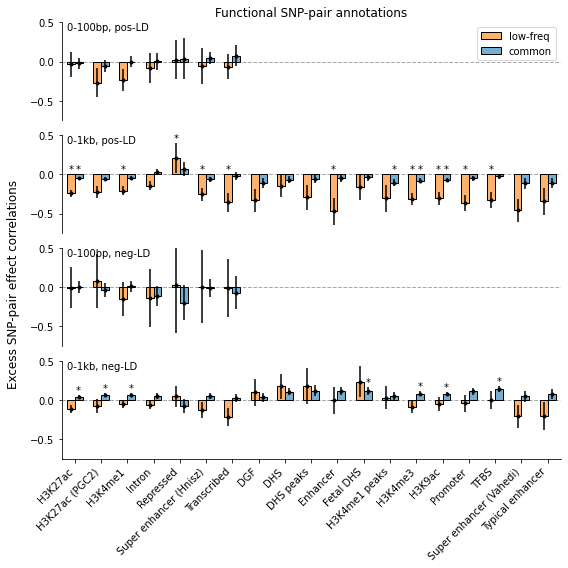

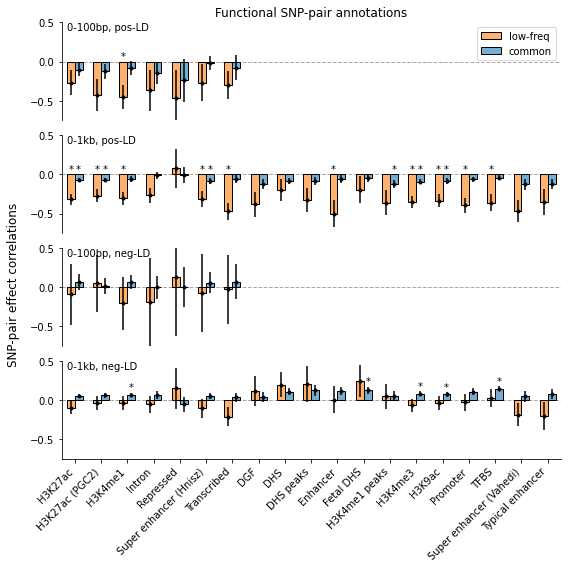

In [11]:
print('# hypothesis: %d' % len(pAN_list))

for term in ['ecor', 'cor']:
    # df_plot
    df_plot = pd.DataFrame(
        index = plot_list, dtype=float,
        columns = [
            '%s.%s.%s%s' % (x, y, z, q)
            for x in ['0_100', '0_1000'] 
            for y in ['p0_p100', 'n100_p0'] 
            for z in ['common', 'lf'] 
            for q in ['', '.se', '.p', '.fwer', '.sig_str'] 
        ]
    )
    for dbin in ['0_100', '0_1000']:
        for lbin in ['p0_p100', 'n100_p0']:
            for mbin in ['common', 'lf']:
                for pannot in plot_list:
                    row = 'pAN:%s_proxy_%s_ld_%s_maf_%s_block'%(pannot,dbin,lbin,mbin)
                    if row not in dic_res_meta[md]['omega'].index:
                        continue
                    df_plot.loc[pannot, '%s.%s.%s'%(dbin,lbin,mbin)] = \
                        dic_res_meta[md]['omega'].loc[row, '%s'%term]
                    df_plot.loc[pannot, '%s.%s.%s.se'%(dbin,lbin,mbin)] = \
                        dic_res_meta[md]['omega'].loc[row, '%s_se'%term]
                    df_plot.loc[pannot, '%s.%s.%s.p'%(dbin,lbin,mbin)] = \
                        dic_res_meta[md]['omega'].loc[row, '%s_p'%term]
                df_plot['%s.%s.%s.fwer'%(dbin,lbin,mbin)] = \
                    df_plot['%s.%s.%s.p'%(dbin,lbin,mbin)] * len(pAN_list)
                df_plot['%s.%s.%s.sig_str'%(dbin,lbin,mbin)] = [
                    '*' if x<0.05 else '' for x in df_plot['%s.%s.%s.fwer'%(dbin,lbin,mbin)]
                ]
                
    if term == 'ecor':
        display(df_plot.loc[['H3K27ac_Hnisz', 'Repressed_Hoffman'], 
                            [x for x in df_plot if '0_1000.p0_p100.common' in x]])
        display(df_plot.loc[['H3K27ac_Hnisz', 'Repressed_Hoffman'], 
                            [x for x in df_plot if '0_1000.p0_p100.lf' in x]])
        df_plot.to_csv(TAB_PATH+'/fig3.tsv', sep='\t')
    
    # Figure
    fig = plt.figure(figsize=[8,8])
    for i_plot,(dbin,lbin) in enumerate([
        ('0_100','p0_p100'), ('0_1000','p0_p100'), ('0_100','n100_p0'), ('0_1000','n100_p0'),
    ]):
        ax = plt.subplot(4,1,i_plot+1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i_plot<3:
            ax.spines['bottom'].set_visible(False)
        for i_mbin,mbin in enumerate(['lf', 'common']):
            plt.errorbar(
                np.arange(df_plot.shape[0])-0.15+0.3*i_mbin, df_plot['%s.%s.%s'%(dbin,lbin,mbin)], 
                yerr=df_plot['%s.%s.%s.se'%(dbin,lbin,mbin)]*1.96, fmt= '.', color='k', 
            )    
            plt.bar(
                np.arange(df_plot.shape[0])-0.15+0.3*i_mbin, df_plot['%s.%s.%s'%(dbin,lbin,mbin)], 
                width=0.3, alpha=1, linewidth=1, edgecolor='k', label=DIC_NAME[mbin], color=DIC_COLOR[mbin],
            )
            for i_row,row in enumerate(df_plot.index):
                plt.text(
                    i_row-0.15+0.3*i_mbin, 
                    max(0,(df_plot.loc[row, '%s.%s.%s'%(dbin,lbin,mbin)] + 
                           df_plot.loc[row,'%s.%s.%s.se'%(dbin,lbin,mbin)]*1.96)),
                    df_plot.loc[row, '%s.%s.%s.sig_str'%(dbin,lbin,mbin)], ha='center', va='bottom'
                ) 
        plt.plot([-0.5, df_plot.shape[0]-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
        plt.xlim([-0.5, df_plot.shape[0]-0.5])
        plt.ylim([-0.75, 0.5])
        plt.text(-0.3, 0.5, dic_name[(dbin,lbin)], ha='left', va='top')
        if i_plot==0:
            plt.title('Functional SNP-pair annotations' )
            plt.legend(loc='upper right')
        if i_plot<3:
            plt.xticks([], [])
        if i_plot==3:
            plt.xticks(np.arange(df_plot.shape[0]), [DIC_NAME[x] for x in df_plot.index], rotation=45, ha='right')
    
    if term == 'ecor':
        fig.supylabel('Excess SNP-pair effect correlations')
    if term == 'cor':
        fig.supylabel('SNP-pair effect correlations')
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/fig3.%s.pdf' % term)
    plt.show()

In [12]:
# p-value for difference 
md = 'md_prox_gene_fct_all_ld'
term = 'ecor' 
prox_list = ['proxy_0_100', 'proxy_100_1000', 'proxy_1000_10000']
gene_list = ['exon', 'exonic_gene', 'cS2G_promoter', 'protein_domain', 'gene']
compare_dic = {
    'lf_posld;0_100;0_1000' : 
        [('pAN:%s_proxy_@_ld_p0_p100_maf_lf_block'%x, ('0_100', '0_1000')) for x in plot_list_100],
    'posld;common;lf' : 
        [('pAN:%s_proxy_0_100_ld_p0_p100_maf_@_block'%x, ('common', 'lf')) for x in plot_list_100] +\
        [('pAN:%s_proxy_0_1000_ld_p0_p100_maf_@_block'%x, ('common', 'lf')) for x in plot_list_1k],
    'n100_p0;p0_p100' : 
        [('pAN:%s_proxy_0_100_ld_@_maf_common_block'%x, ('n100_p0', 'p0_p100')) for x in plot_list_100] +\
        [('pAN:%s_proxy_0_100_ld_@_maf_lf_block'%x, ('n100_p0', 'p0_p100')) for x in plot_list_100] +\
        [('pAN:%s_proxy_0_1000_ld_@_maf_common_block'%x, ('n100_p0', 'p0_p100')) for x in plot_list_1k] +\
        [('pAN:%s_proxy_0_1000_ld_@_maf_lf_block'%x, ('n100_p0', 'p0_p100')) for x in plot_list_1k],
}



df_jndif_list = []
for compare_term in compare_dic:
    print(compare_term)
    if compare_term =='lf_posld;0_100;0_1000':
        n_hypothesis = 7
    else:
        n_hypothesis = len(pAN_list) / 2
    compare_list = compare_dic[compare_term]
    df_res = pd.DataFrame(
        columns=['pAN', 'strat1', 'start2', 'pAN1', 'mean1', 'se1', 'pAN2', 'mean2', 'se2', 
                 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str'], 
        dtype=float,
    )
    for i_pair, (pAN, (strat1, strat2)) in enumerate(compare_list):
        pAN1,pAN2 = pAN.replace('@', strat1),pAN.replace('@', strat2)
        esti_list,se_list = [],[]
        df_res.loc[i_pair, ['pAN', 'strat1', 'start2', 'pAN1', 'pAN2']] = [pAN, strat1, strat2, pAN1, pAN2]
        df_res.loc[i_pair, ['mean1', 'se1']] = dic_res_meta[md]['omega'].loc[pAN1, [term, '%s_se'%term]].values
        df_res.loc[i_pair, ['mean2', 'se2']] = dic_res_meta[md]['omega'].loc[pAN2, [term, '%s_se'%term]].values
        for trait in TRAIT_LIST_INDPT:
            temp_dic_jn = dic_res[md][trait]['summary']['dic_jn']
            esti1 = {x:y for x,y in zip(temp_dic_jn['res_pAN_list'], temp_dic_jn[term])}[pAN1]
            esti2 = {x:y for x,y in zip(temp_dic_jn['res_pAN_list'], temp_dic_jn[term])}[pAN2]
            temp_df = pd.DataFrame(data=temp_dic_jn['%s.jn'%term], columns=temp_dic_jn['res_pAN_list'])
            v_mean_jn, mat_cov_jn = ldspec.regress.bjn(
                [esti1 - esti2], temp_df[pAN1] - temp_df[pAN2], temp_dic_jn['v_h']
            )
            esti_list.append(v_mean_jn[0])
            se_list.append(np.sqrt(mat_cov_jn[0,0]))        
        mean_,se_ = ldspec.util.meta_analysis(np.array(esti_list), np.array(se_list))
        p_ = ldspec.util.zsc2pval(mean_ / se_)
        df_res.loc[i_pair, ['dif', 'dif_se', 'dif_p']] = [mean_, se_, p_]
    df_res['dif_fwer'] = df_res['dif_p'] * n_hypothesis
    print('# hypothesis: %d' % n_hypothesis)
    df_res['dif_sig_str'] = ['*' if x<0.05 else '' for x in df_res['dif_fwer']]
    
    df_res['pAN'] = [
        x.replace('pAN:','').replace('_proxy','').replace('_ld','').replace('_block','') 
        for x in df_res['pAN']
    ]
    display(df_res[[
        'pAN', 'strat1', 'start2', 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str', 
        'mean1', 'se1', 'mean2', 'se2', 
    ]])
    
    df_jndif_list.append(
        df_res[['pAN', 'strat1', 'start2', 'dif', 'dif_se', 'dif_p', 'dif_fwer', 'dif_sig_str']]
    )
df_jndif = pd.concat(df_jndif_list, axis=0)
df_jndif.to_csv(TAB_PATH+'/fig3.jndif.tsv', sep='\t', index=False)

lf_posld;0_100;0_1000
# hypothesis: 7


,pAN,strat1,start2,dif,dif_se,dif_p,dif_fwer,dif_sig_str,mean1,se1,mean2,se2
0,H3K27ac_Hnisz_@_p0_p100_maf_lf,0_100,0_1000,0.210902,0.072509,0.003630,0.025412,*,-0.031195,0.081316,-0.239625,0.023662
1,H3K27ac_PGC2_@_p0_p100_maf_lf,0_100,0_1000,-0.028118,0.100968,0.780640,5.464481,,-0.266935,0.092416,-0.224703,0.041972
2,H3K4me1_Trynka_@_p0_p100_maf_lf,0_100,0_1000,-0.018452,0.070121,0.792443,5.547102,,-0.234402,0.072430,-0.209693,0.029084
3,Intron_UCSC_@_p0_p100_maf_lf,0_100,0_1000,0.095421,0.090032,0.289213,2.024491,,-0.078428,0.097933,-0.145362,0.028905
4,Repressed_Hoffman_@_p0_p100_maf_lf,0_100,0_1000,-0.179586,0.169823,0.290290,2.032029,,0.023901,0.127158,0.207980,0.099236
5,SuperEnhancer_Hnisz_@_p0_p100_maf_lf,0_100,0_1000,0.204631,0.130831,0.117797,0.824582,,-0.055632,0.114966,-0.253869,0.042971
6,Transcribed_Hoffman_@_p0_p100_maf_lf,0_100,0_1000,0.283826,0.083721,0.000699,0.004890,*,-0.063222,0.083821,-0.355303,0.062089


posld;common;lf
# hypothesis: 68


,pAN,strat1,start2,dif,dif_se,dif_p,dif_fwer,dif_sig_str,mean1,se1,mean2,se2
0,H3K27ac_Hnisz_0_100_p0_p100_maf_@,common,lf,0.033284,0.093221,7.210564e-01,4.903184e+01,,-0.023309,0.034681,-0.031195,0.081316
1,H3K27ac_PGC2_0_100_p0_p100_maf_@,common,lf,0.176766,0.110832,1.107348e-01,7.529967e+00,,-0.059323,0.040214,-0.266935,0.092416
2,H3K4me1_Trynka_0_100_p0_p100_maf_@,common,lf,0.213050,0.080656,8.254858e-03,5.613303e-01,,0.000763,0.036897,-0.234402,0.072430
3,Intron_UCSC_0_100_p0_p100_maf_@,common,lf,0.074166,0.133121,5.774365e-01,3.926569e+01,,0.006007,0.054554,-0.078428,0.097933
4,Repressed_Hoffman_0_100_p0_p100_maf_@,common,lf,0.035924,0.207110,8.622943e-01,5.863602e+01,,0.036373,0.132828,0.023901,0.127158
5,SuperEnhancer_Hnisz_0_100_p0_p100_maf_@,common,lf,0.104830,0.134927,4.371951e-01,2.972927e+01,,0.047922,0.038763,-0.055632,0.114966
6,Transcribed_Hoffman_0_100_p0_p100_maf_@,common,lf,0.101010,0.109068,3.543837e-01,2.409809e+01,,0.074545,0.067297,-0.063222,0.083821
7,DGF_ENCODE_0_1000_p0_p100_maf_@,common,lf,0.211200,0.101907,3.822021e-02,2.598974e+00,,-0.110660,0.030863,-0.330439,0.076891
8,DHS_Trynka_0_1000_p0_p100_maf_@,common,lf,0.108990,0.074284,1.423171e-01,9.677566e+00,,-0.065449,0.020409,-0.145048,0.070629
9,DHS_peaks_Trynka_0_1000_p0_p100_maf_@,common,lf,0.284905,0.086557,9.963862e-04,6.775426e-02,,-0.063420,0.025703,-0.293244,0.079538


n100_p0;p0_p100
# hypothesis: 68


,pAN,strat1,start2,dif,dif_se,dif_p,dif_fwer,dif_sig_str,mean1,se1,mean2,se2
0,H3K27ac_Hnisz_0_100_@_maf_common,n100_p0,p0_p100,0.024652,0.043698,5.726548e-01,3.894053e+01,,0.004970,0.039046,-0.023309,0.034681
1,H3K27ac_PGC2_0_100_@_maf_common,n100_p0,p0_p100,-0.013447,0.048582,7.819468e-01,5.317238e+01,,-0.031530,0.045224,-0.059323,0.040214
2,H3K4me1_Trynka_0_100_@_maf_common,n100_p0,p0_p100,0.000936,0.043255,9.827423e-01,6.682648e+01,,0.015506,0.035664,0.000763,0.036897
3,Intron_UCSC_0_100_@_maf_common,n100_p0,p0_p100,-0.087337,0.082261,2.883684e-01,1.960905e+01,,-0.112393,0.064095,0.006007,0.054554
4,Repressed_Hoffman_0_100_@_maf_common,n100_p0,p0_p100,-0.173259,0.164923,2.934695e-01,1.995593e+01,,-0.196569,0.111894,0.036373,0.132828
5,SuperEnhancer_Hnisz_0_100_@_maf_common,n100_p0,p0_p100,-0.067316,0.066611,3.122159e-01,2.123068e+01,,-0.009268,0.060667,0.047922,0.038763
6,Transcribed_Hoffman_0_100_@_maf_common,n100_p0,p0_p100,-0.151332,0.116972,1.957540e-01,1.331127e+01,,-0.067600,0.105706,0.074545,0.067297
7,H3K27ac_Hnisz_0_100_@_maf_lf,n100_p0,p0_p100,-0.094688,0.167969,5.729416e-01,3.896003e+01,,-0.004843,0.134601,-0.031195,0.081316
8,H3K27ac_PGC2_0_100_@_maf_lf,n100_p0,p0_p100,0.299732,0.182538,1.005838e-01,6.839699e+00,,0.081318,0.173895,-0.266935,0.092416
9,H3K4me1_Trynka_0_100_@_maf_lf,n100_p0,p0_p100,0.028749,0.107745,7.896031e-01,5.369301e+01,,-0.155095,0.111128,-0.234402,0.072430


### scv vs. h2, h2_shrink

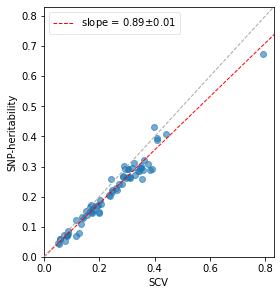

Heritability shrinkage: mean=0.871 se=0.017 p=1.584e-13


In [13]:
# h2 vs. scv across traits
md = 'md_prox_gene_fct_all_ld'
df_plot = pd.DataFrame(
    index=TRAIT_LIST, columns=['h2', 'h2_se', 'scv', 'scv_se', 'h2_shrink', 'h2_shrink_se'], dtype=float,
)
for trait in TRAIT_LIST:
    df_plot.loc[trait] = dic_res[md][trait]['summary']['tau'].loc\
        ['AN:all', ['h2', 'h2_se', 'scv', 'scv_se', 'h2_shrink', 'h2_shrink_se']].values
df_plot.to_csv(TAB_PATH+'/fig5.tsv', sep='\t')
    
res = smf.ols("h2 ~ scv - 1", df_plot.loc[TRAIT_LIST_INDPT]).fit()
sl,sl_se = res.params[0],res.bse[0]
eq_str = '%0.2f$\pm$%0.2f' % (sl, sl_se)

plt.figure(figsize=[4,4.2])
plt.scatter(df_plot['scv'], df_plot['h2'], alpha=0.6)
# reference lines
max_ = max(plt.xlim()[1], plt.ylim()[1])
plt.plot([0, 2], [0*sl, 2*sl], '--', linewidth=1, alpha=1, color='r', zorder=10, label='slope = %s' % eq_str)
plt.plot([0, max_], [0, max_], '--', linewidth=1, color='darkgrey', zorder=10)
plt.xlim([0, max_])
plt.ylim([0, max_])
plt.xlabel('SCV')
plt.ylabel('SNP-heritability')
plt.legend(loc='upper left', framealpha=0.5)
plt.tight_layout()
plt.savefig(FIG_PATH + '/fig5.pdf')
plt.show()

# h2_shrink across traits 
df_stats = pd.DataFrame(index=TRAIT_LIST_INDPT, columns=['mean', 'se'])
for trait in TRAIT_LIST_INDPT:
    df_stats.loc[trait, ['mean', 'se']] = \
        dic_res[md][trait]['summary']['tau'].loc['AN:all', ['h2_shrink', 'h2_shrink_se']].values
    
mean_ = df_stats['mean'].mean()
se_ = df_stats['mean'].std() / np.sqrt(df_stats.shape[0])
p_ = ldspec.util.zsc2pval((mean_-1) / se_)
print('Heritability shrinkage: mean=%0.3f se=%0.3f p=%0.3e' % (mean_, se_, p_))

In [14]:
# functional annotations with SNP-pair and enrichment heritability 
for mbin in ['common', 'lf']:
    for dbin in ['0_100', '0_1000']:
        temp_list = [
            x for x in dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['tau'].index 
            if x.replace('AN', 'pAN').replace('_%s'%mbin, '_proxy_%s_ld_p0_p100_maf_%s_block'%(dbin,mbin)) in 
            dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['omega'].index
        ]
        # further restricting to ones with enriched h2
#         temp_list = [x for x in temp_list if dic_res_meta[md]['tau'].loc[x, 'h2_enrich']>1]
        print(mbin, dbin, len(temp_list))
#         display(dic_res_meta[md]['tau'].loc[temp_list, ['h2_enrich', 'h2_shrink']])

        esti_list,se_list = [],[]
        for trait in TRAIT_LIST_INDPT:
            temp_dic_jn = dic_res[md][trait]['summary']['dic_jn']
            temp_dic = {
                x:y/z for x,y,z in zip(temp_dic_jn['res_AN_list'], temp_dic_jn['h2'], temp_dic_jn['scv'])
            }
            esti = np.mean([temp_dic[x] for x in temp_list])
            jn_list = []
            for i_jn in range(temp_dic_jn['v_h'].shape[0]):
                temp_dic = {x:y/z for x,y,z in zip(
                    temp_dic_jn['res_AN_list'], temp_dic_jn['h2.jn'][i_jn,:], temp_dic_jn['scv.jn'][i_jn,:],
                )}
                esti_jn = np.mean([temp_dic[x] for x in temp_list])
                jn_list.append(esti_jn)
            # genomic JN of mean across annotations in temp_list
            v_mean_jn, mat_cov_jn = ldspec.regress.bjn([esti], jn_list, temp_dic_jn['v_h'] )
            esti_list.append(v_mean_jn[0])
            se_list.append(np.sqrt(mat_cov_jn[0,0]))

        mean_,se_ = ldspec.util.meta_analysis(np.array(esti_list), np.array(se_list))
        p_ = ldspec.util.zsc2pval((mean_-1) / se_)
        print('mean=%0.4f, se=%0.4f, p=%0.4e' % (mean_, se_, p_))

common 0_100 6


/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in float_scalars
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in float_scalars


mean=0.8319, se=0.0100, p=2.3117e-63
common 0_1000 18
mean=0.8351, se=0.0075, p=1.8894e-107
lf 0_100 6
mean=0.8430, se=0.0086, p=3.2177e-75
lf 0_1000 18
mean=0.8731, se=0.0092, p=3.6813e-43


In [15]:
# h2_shrink across annotations 
md = 'md_prox_gene_fct_all_ld'

AN_fct_list = dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['tau'].index[
    dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['tau']['type']=='binary'
]
AN_fct_list = [x for x in AN_fct_list if ('flanking' not in x) & (x!='AN:all') & ('AN:mbin' not in x)]

temp_df = dic_res_meta[md]['tau'].loc[AN_fct_list].copy()
temp_df = temp_df.sort_values(by='h2_shrink')
print('all fct AN', temp_df.shape[0])
temp_df = temp_df.loc[temp_df['h2_shrink_p']<0.05/165]
print('sig fct AN', temp_df.shape[0])
temp_df['name'] = [DF_ANNOT.loc[x.replace('AN:','').replace('_common',''), 'Name'] for x in temp_df.index]
display(temp_df[['h2_shrink', 'h2_shrink_se', 'h2_shrink_p', 'name']])

all fct AN 76
sig fct AN 11


,h2_shrink,h2_shrink_se,h2_shrink_p,name
AN:SuperEnhancer_Hnisz_common,0.779534,0.010133,0.000183,Super enhancer (Hnisz)
AN:H3K4me3_Trynka_common,0.798893,0.007793,0.000156,H3K4me3
AN:H3K27ac_Hnisz_common,0.808771,0.009058,0.000030,H3K27ac
AN:H3K9ac_Trynka_common,0.818920,0.007121,0.000018,H3K9ac
AN:TFBS_ENCODE_common,0.830670,0.009757,0.000082,TFBS
AN:BivFlnk_common,0.904040,0.006877,0.000028,Flanking bivalent TSS/enhancer
AN:H3K4me3_peaks_Trynka_common,0.925616,0.006614,0.000011,H3K4me3 peaks
AN:H3K9ac_peaks_Trynka_common,0.944119,0.004756,0.000014,H3K9ac peaks
AN:WeakEnhancer_Hoffman_common,0.953036,0.008069,0.000279,Weak enhancer
AN:PromoterFlanking_Hoffman_common,0.979335,0.011410,0.000058,Promoter flanking


In [16]:
# lf vs. common
common_list = [x for x in AN_fct_list if x.endswith('common')]
lf_list = [x for x in AN_fct_list if x.endswith('lf')]
print('AN_fct_list', len(AN_fct_list))
print('common_list', len(common_list))
print('lf_list', len(lf_list))

esti1_list,se1_list = [],[]
esti2_list,se2_list = [],[]
esti3_list,se3_list = [],[]
for trait in TRAIT_LIST_INDPT:
    temp_dic_jn = dic_res[md][trait]['summary']['dic_jn']
    temp_dic = {x:y/z for x,y,z in zip(temp_dic_jn['res_AN_list'], temp_dic_jn['h2'], temp_dic_jn['scv'])}
    esti1 = np.mean([temp_dic[x] for x in common_list])
    esti2 = np.mean([temp_dic[x] for x in lf_list])
    jn1_list,jn2_list,jn3_list = [],[],[]
    for i_jn in range(temp_dic_jn['v_h'].shape[0]):
        temp_dic = {x:y/z for x,y,z in zip(
            temp_dic_jn['res_AN_list'], temp_dic_jn['h2.jn'][i_jn,:], temp_dic_jn['scv.jn'][i_jn,:],
        )}
        esti1_jn = np.mean([temp_dic[x] for x in common_list])
        esti2_jn = np.mean([temp_dic[x] for x in lf_list])
        jn1_list.append(esti1_jn)
        jn2_list.append(esti2_jn)
        jn3_list.append(esti1_jn-esti2_jn)
    # common
    v_mean_jn, mat_cov_jn = ldspec.regress.bjn([esti1], jn1_list, temp_dic_jn['v_h'] )
    esti1_list.append(v_mean_jn[0])
    se1_list.append(np.sqrt(mat_cov_jn[0,0])) 
    # lf
    v_mean_jn, mat_cov_jn = ldspec.regress.bjn([esti2], jn2_list, temp_dic_jn['v_h'] )
    esti2_list.append(v_mean_jn[0])
    se2_list.append(np.sqrt(mat_cov_jn[0,0])) 
    # dif
    v_mean_jn, mat_cov_jn = ldspec.regress.bjn([esti1-esti2], jn3_list, temp_dic_jn['v_h'] )
    esti3_list.append(v_mean_jn[0])
    se3_list.append(np.sqrt(mat_cov_jn[0,0])) 

# common
mean_,se_ = ldspec.util.meta_analysis(np.array(esti1_list), np.array(se1_list))
p_ = ldspec.util.zsc2pval((mean_-1) / se_)
print('common: mean=%0.3f, se=%0.3f, p=%0.3e' % (mean_, se_, p_))
# lf
mean_,se_ = ldspec.util.meta_analysis(np.array(esti2_list), np.array(se2_list))
p_ = ldspec.util.zsc2pval((mean_-1) / se_)
print('lf: mean=%0.3f, se=%0.3f, p=%0.3e' % (mean_, se_, p_))
# dif
mean_,se_ = ldspec.util.meta_analysis(np.array(esti3_list), np.array(se3_list))
p_ = ldspec.util.zsc2pval(mean_ / se_)
print('dif: mean=%0.3f, se=%0.3f, p=%0.3e' % (mean_, se_, p_))

AN_fct_list 76
common_list 38
lf_list 38


/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in float_scalars
  del sys.path[0]
/home/jz286/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in float_scalars


common: mean=0.901, se=0.023, p=2.352e-05
lf: mean=0.934, se=0.062, p=2.874e-01
dif: mean=0.116, se=0.165, p=4.794e-01


### h2 between baseline-SP and baseline

In [17]:
# h2 w/ and w/o modeling SNP pair correlations 
md1 = 'md_prox_gene_fct_all_ld'
md2 = 'md_bsl'
df_stats = pd.DataFrame(index=TRAIT_LIST_INDPT, columns=['mean1', 'se1', 'mean2', 'se2'])
for trait in TRAIT_LIST_INDPT:
    df_stats.loc[trait, ['mean1', 'se1']] = \
        dic_res[md1][trait]['summary']['tau'].loc['AN:all', ['h2', 'h2_se']].values
    df_stats.loc[trait, ['mean2', 'se2']] = \
        dic_res[md2][trait]['summary']['tau'].loc['AN:all', ['h2', 'h2_se']].values
df_stats['ratio'] = df_stats['mean1'] / df_stats['mean2']
mean_ = df_stats['ratio'].mean()
se_ = df_stats['ratio'].std() / np.sqrt(df_stats.shape[0])
p_ = ldspec.util.zsc2pval((mean_-1) / se_)
print('Heritability  SP vs. bsl: ratio=%0.3f se=%0.3f p=%0.3e' % (mean_, se_, p_))

Heritability  SP vs. bsl: ratio=1.023 se=0.003 p=5.641e-13


### Old code